# Preamble
Import CASA and other necessary bits for this workbook. You can safely ignore the intricacies of the following cell

In [1]:
import sys
import os
import shutil
from IPython.display import display
import ipywidgets as widgets
import tempfile
from casatools import table
tb = table()
import numpy as np
from casatools import quanta
quanta = quanta()
import pyvirtualdisplay
from datetime import datetime
from datetime import timezone
from matplotlib import pyplot as plt

_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
_ = _display.start()

assert os.getenv('DISPLAY') != "" and os.getenv('DISPLAY') is not None
print('X11 Virtual Frame Buffer startup completed')

from casatasks import casalog
currentlogpos = 0
def runcasa(f, *args, **kwargs):
  """
    Runs a CASA task and prints the log
    Args:
      f: task method
      *args: positional arguments to the task f
      **kwargs: named arguments to the task f
    Returns the return value of f or None if failed
  """
  global currentlogpos
  if not os.path.exists(casalog.logfile()):
    with open(casalog.logfile(), "w+") as casalogfile:
      pass
  with open(casalog.logfile(), "r") as casalogfile:
    casalogfile.seek(currentlogpos)
    try:
      res = f(*args, **kwargs)
    finally:
      print(casalogfile.read())
      currentlogpos = casalogfile.tell()
  return res

# define the tasks on the current stack
# and wrap them inside a logger reader
import casatasks
import casatools
import casaplotms
from IPython.display import Image

def wrap_task(mod, tasks):
  for task in tasks:
    def logclosure(task):
      return lambda *args, **kwargs: runcasa(getattr(mod, task),
                                             *args,
                                             **kwargs)
    setattr(sys.modules[__name__], 
        task,
        logclosure(task))
    getattr(sys.modules[__name__], task).__doc__ = \
      getattr(mod, task).__doc__

wrap_task(casatools, ['agentflagger','atcafiller','atmosphere','calanalysis',
                      'calibrater','casadata','coercetype','componentlist',
                      'coordsys','ctsys','ctuser','errors','image','imagemetadata',
                      'imagepol','imager','iterbotsink','linearmosaic','logsink',
                      'measures','miriadfiller','ms','msmetadata','mstransformer',
                      'quanta','regionmanager','sakura','sdm',
                      'sidebandseparator','simulator','singledishms','spectralline',
                      'synthesisdeconvolver','synthesisimager','synthesisimstore',
                      'synthesismaskhandler','synthesisnormalizer','synthesisutils',
                      'table','typecheck','utils','version','version_string',
                      'vlafiller','vpmanager'])

wrap_task(casatasks, ['accor','apparentsens','applycal',
                      'asdmsummary','bandpass',
                      'blcal','calstat',
                      'clearcal',
                      'clearstat','concat','config',
                      'conjugatevis','cvel','cvel2',
                      'delmod','exportasdm','exportfits',
                      'exportuvfits','feather','fixplanets',
                      'fixvis','flagcmd','flagdata','flagmanager',
                      'fluxscale','fringefit','ft','gaincal',
                      'gencal','hanningsmooth','imcollapse',
                      'imcontsub','imdev','imfit','imhead',
                      'imhistory','immath','immoments','impbcor','importasap',
                      'importasdm','importatca','importfits','importfitsidi','importgmrt',
                      'importlib','importmiriad','importnro','importuvfits','importvla',
                      'impv','imrebin','imreframe','imregrid','imsmooth','imstat',
                      'imsubimage','imtrans','imval','initweights','listcal',
                      'listfits','listhistory','listobs','listpartition','listsdm',
                      'listvis','makemask','mstransform','nrobeamaverage',
                      'partition','plotants','plotbandpass','plotprofilemap',
                      'plotweather','polcal','polfromgain','predictcomp','rerefant',
                      'rmfit','rmtables','sdatmcor','sdbaseline','sdcal',
                      'sdfit','sdfixscan','sdgaincal','sdimaging','sdintimaging',
                      'sdpolaverage','sdsidebandsplit','sdsmooth','sdtimeaverage',          
                      'setjy','simalma','simanalyze','simobserve','slsearch','smoothcal',
                      'specfit','specflux','specsmooth','splattotable','split',
                      'spxfit','statwt','tclean','testconcat','tsdimaging','uvcontsub',
                      'uvmodelfit','uvsub','virtualconcat','vishead',
                      'visstat','widebandpbcor'])
wrap_task(casaplotms, ["plotms"])
print('CASA import and initialization completed')

X11 Virtual Frame Buffer startup completed
CASA import and initialization completed


In [2]:
archive_fn = os.path.join(os.path.abspath(""), "tart.2022.11.22.10-12utc.pp.ms.tar.gz")
MSNAME = os.path.join(os.path.abspath(""), 'tart.ms')
OVERWRITE=False # true if you want to overwrite
##################################
##################################
##################################
if not os.path.exists(archive_fn):
    raise RuntimeError(f"Failed to find archive '{archive_fn}'. Check your git clone")
if OVERWRITE and os.path.exists(MSNAME):
    shutil.rmtree(MSNAME)
if OVERWRITE:
    !tar xvf {archive_fn}
assert os.path.exists(MSNAME)

# Two-element interferometer and linkage to TART 
We first boil the geometry of interferometry down to its most essential subcomponent: a two-element interferometer. Each pair of antennas within a larger interferometer forms a baseline measuring a single spacial frequency of the sky (or visibility). The samples of all such two-element spacings are in the end combined to build up coverage in the synthesized aperture coordinate frame (or $uv$ plane). Shorter baselines contribute measurements to larger scales (resolved Active Galactic Nuclei jets, resolved galactic plane emission, etc.) and longer baselines contribute measurements to finer scales on the sky (distant unresolved point-like AGN for example).

The two-element interferometer measures not only the radiative power from sources, but also the differential delay between the propagated wave reaching the first antenna and the second antenna, from a source radiating in the far field. The delay ($\tau$) is 0 when the source direction vector ($\vec{S}(l,m)$) is aligned with the phase tracking centre ($\vec{S}_0(l,m)$) of the telescope. Due to the limited bandwidth and integration intervals used when correlating the interferometer has a maximal response in all directions orthogonal to the baseline. This is the default phase tracking centre of the telescope.

A single two element interferometer measures both the even (cosine) and the odd (sine) spatial frequencies of the sky brightness distributions -- as they are projected onto the baseline. The product measured, for a perfectly calibrated omni-directional two-element interferometer is a visibility
\begin{equation}
V(u,v,w) = \int_{lm}{I(l,m,\nu)\exp{(-2\pi i\tau/\lambda)} \frac{dldm}{n}}
\end{equation}

The visibility (complex-valued) essentially tells us how resolved a source is at the spatial scale measured by the baseline. An unresolved source is much smaller than the resulting fringe of the longest spacing in the array. It therefore has a constant power across all the composing baselines, whereas a large source is said to be resolved on a baseline if it is spacially much larger than the fringe period of that spacing (ie. the integral over the fringes tends to 0 across the extent of the source).

In practice we can use the Fourier shift theorem to change the tracking centre of our telescope to have zero phase towards any point on the celestial sphere. This is done by adding in an additional delay to the geometric phase. The net effect tilts each of the composing two-element interferometers to have a 0 phase towards a new point, $\vec{S}_i(l,m)$. In large interferometers this geometric term shifts much quicker than the integration interval and is done inside the correlator. On TART the resolution is poor, which means that the integration interval (adjustable, but on the orders of a few seconds) is substantially shorter than the time it takes for a source to move even a fraction of the instrumental resolution. We can therefore apply the term after correlation.

Lastly, the signal path is never perfectly calibrated. for a single feed system we can write the visibility term with complex valued gains (equivalently Jones matrices in orthogonal feeds). These are subscribed by $p$ and $q$ for arbitrary antennas $p$ and $q$. These terms can be cable delays (phase slopes as a function of frequency), time-variable phases and amplitudes due to the electronics and ionospheric phase (at cm-wavelengths). These gains apply equally to all areas of the observed sky and are called direction-independent (or second-generation) effects. The following is an example of such a Radio Interferometric Measurement Equation (RIME). 
\begin{equation}
V(u,v,w) = G_p(t,\nu)\int_{lm}{I(l,m,\nu)\exp{(-2\pi i\tau/\lambda)} \frac{dldm}{n}}G^H_q(t,\nu)
\end{equation}

We can add additional direction-dependent (or third-generation) terms. The most prominent of these is the far field response of the antennas, which is (approximately) the Fourier transform of the voltage grading function on the antenna collecting surface and may not be uniformly sensitive over the entire field of view. We will call the far field responses E_p(l,m,\nu) and E_q(l,m,\nu). The RIME then becomes a bit more complicated
\begin{equation}
\begin{split}
V(u,v,w) = G_p(t,\nu)\int_{lm}{E_p(l,m,\nu)I(l,m,\nu)\exp{(-2\pi i\tau/\lambda)E^H_q(l,m,\nu)} \frac{dldm}{n}}G^H_q(t,\nu)
\end{split}
\end{equation}

Telescope calibration attempts to remove these complex gain terms. This will be the topic of discussion in this notebook and have to be applied before images can be made. We will use the Common Astronomy Software Applications (CASA) version 6.5 to correct for these terms.

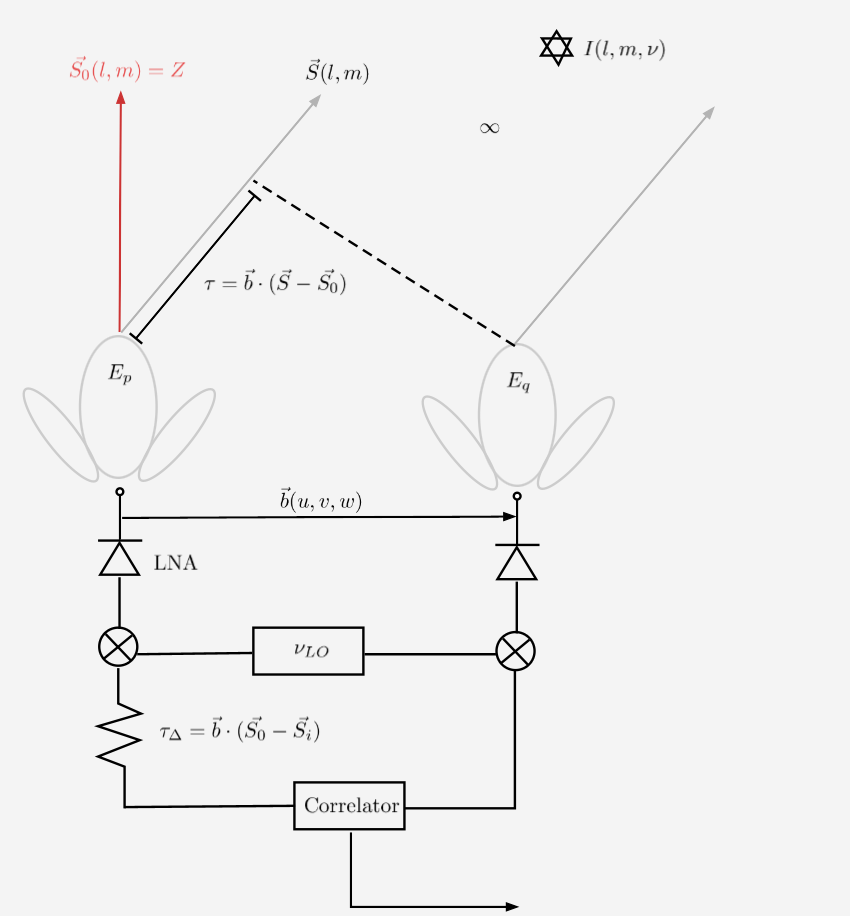

In [4]:
Image(os.path.join(os.path.abspath(""), "imgs", "two.element.interferometer.png"))

With the component two-element interferometer in hand we can look at the distribution of visibilities in the synthesized aperture plane that results from observation with an array interferometer. Remember that the tracking coordinates are defined as offsets to the celestial frame (X pointing towards the meridian at the celestial equator, Y pointing East and Z pointing towards celestial north).
\begin{equation}
\begin{pmatrix}
u \\
v \\
w
\end{pmatrix} = \begin{pmatrix} 
\sin(H_0) & \cos(H_0) & 0 \\
-\sin(\delta_0)\cos(H_0) & \sin(\delta_0)\sin(H_0) & \cos(\delta_0) \\
\cos(\delta_0)\cos(H_0) & -\cos(\delta_0)\sin(H_0) & \sin(\delta_0)
\end{pmatrix}\begin{pmatrix} 
X \\
Y \\
Z
\end{pmatrix}
\end{equation}

$w$ is tilted from the nominal XYZ celestial frame to point towards the tracking centre of the telescope. As the $u$ and $v$ bases are functions of hour angle the baseline coordinates track out a virtual aperture the size of the longest baseline in what is appropriately termed the $uv$ plane. 

We plot the projected $uv(w=0)$ plane for our observation below. For each spacing in this synthesized aperture plane we also get the conjugate spacing for free. As the spatial distribution of power in the sky is real-valued we only need to keep either the baselines or their conjugates.

1888116


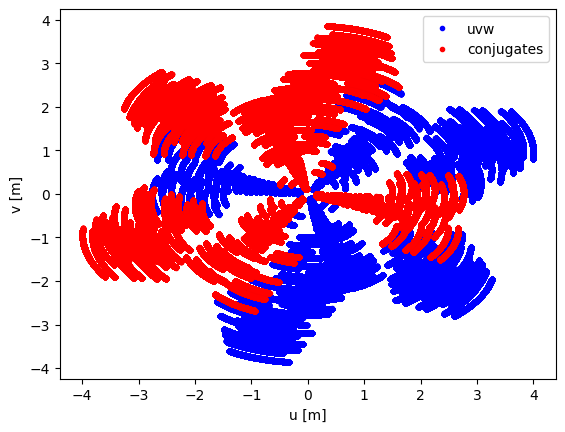

In [3]:
tb.open("tart.ms")
uvw = tb.getcol('UVW').T
tb.close()
plt.figure()
plt.plot(uvw[:,0], uvw[:,1], 'b.', label='uvw')
plt.plot(-uvw[:,0], -uvw[:,1], 'r.', label='conjugates')
plt.xlabel('u [m]')
plt.ylabel('v [m]')
plt.legend()
plt.show()